# Image Augmentation - Color PCA

Note: code borrowed from: [PCAColorAugmentation](https://github.com/koshian2/PCAColorAugmentation)

In [46]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.keras.datasets import cifar10
from tensorflow.python.keras.layers import Layer, InputSpec, Input
from tensorflow.python.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt

## Note
## TensorFlow's GPU SVD is too slow, so if you want to do end-to-end augmentation,
## I recommend to use cpu numpy (tensor version) augmentation.
class PCAColorAugmentationGPU(Layer):
    def __init__(self, std_deviation=0.1, clipping=True, scale=1.0, **kwargs):
        super().__init__(**kwargs)
        self.std_deviation = std_deviation
        self.clipping = clipping
        self.scale = scale

    def build(self, input_shape):
        return super().build(input_shape)

    def augmentation(self, inputs):
        # assume channels-last
        input_shape = K.int_shape(inputs)
        ranks = len(input_shape)
        assert ranks >= 2 and ranks <=5
        chs = input_shape[-1]
        
        # swapaxis, reshape for calculating covariance matrix
        # rank 2 = (batch, dims)
        # rank 3 = (batch, step, dims)
        if ranks <= 3:
            x = inputs
        # rank 4 = (batch, height, width, ch) -> (batch, dims, ch)
        elif ranks == 4:
            dims = input_shape[1] * input_shape[2]
            x = tf.reshape(inputs, (-1, dims, chs))
        # rank 5 = (batch, D, H, W, ch) -> (batch, D, dims, ch)
        elif ranks == 5:
            dims = input_shape[2] * input_shape[3]
            depth = input_shape[1]
            x = tf.reshape(inputs, (-1, depth, dims, chs))

        # scaling-factor
        calculate_axis, reduce_axis = ranks-1, ranks-2
        if ranks == 3:
            calculate_axis, reduce_axis = 1, 2
        elif ranks >= 4:
            calculate_axis, reduce_axis = ranks-3, ranks-2
        C = 1.0
        if ranks >= 3:
            C = K.int_shape(x)[reduce_axis]
        var = K.var(x, axis=calculate_axis, keepdims=True)
        scaling_factors = tf.sqrt(C / tf.reduce_sum(var, axis=reduce_axis, keepdims=True))
        # scaling
        x = x * scaling_factors

        # subtract mean for cov matrix
        mean = tf.reduce_mean(x, axis=calculate_axis, keepdims=True)
        x -= mean

        # covariance matrix
        cov_n = max(K.int_shape(x)[calculate_axis] - 1, 1)
        # cov (since x was normalized)
        cov = tf.matmul(x, x, transpose_a=True) / cov_n

        # eigen value(S), eigen vector(U)
        S, U, V = tf.linalg.svd(cov)
        # eigen_values vs eigen_vectors
        # rank = 2 : (dims) vs (dims, dims)
        # rank = 3 : (batch, dims) vs (batch, dims, dims)
        # rank = 4 : (batch, ch) vs (batch, ch, ch)
        # rank = 5 : (batch, D, ch) vs (batch, D, ch, ch)
        
        # random values
        # if rank2 : get differnt random variable by sample
        if ranks == 2:
            rand = tf.random_normal(tf.shape(inputs), mean=0.0, stddev=self.std_deviation)
            delta = tf.matmul(rand*tf.expand_dims(S, axis=0), U)
        else:
            rand = tf.random_normal(tf.shape(S), mean=0.0, stddev=self.std_deviation)
            delta_original = tf.squeeze(tf.matmul(U, tf.expand_dims(rand*S, axis=-1)), axis=-1)

        # adjust delta shape
        # rank = 3 : (batch, dims) -> (batch, 1[step], dims)
        # rank = 4 : (batch, ch) -> (batch, 1[ndim], ch)
        # rank = 5 : (batch, D, ch) -> (batch, D, 1[ndim], ch)
        if ranks == 3:
            delta = tf.expand_dims(delta_original, axis=ranks-2)
        elif ranks >= 4:
            delta = K.expand_dims(delta_original, axis=ranks-3)
            # reshape to original input shape(if rank >= 4)
            # rank = 4 : (batch, ndim, ch) -> (batch, height, width, ch)
            # rank = 5 : (batch, D, ndim, ch) -> (batch, D, height, width, ch)
            delta = tf.broadcast_to(delta, tf.shape(x))
            delta = K.reshape(delta, [-1, *input_shape[1:]])
        
        # delta scaling
        delta = delta * self.scale

        #print("scaling factor", K.int_shape(scaling_factors))
        #print("mean", K.int_shape(mean))
        #print("cov", K.int_shape(cov))
        #print("S", K.int_shape(S))
        #print("U", K.int_shape(U))
        #print("rand", K.int_shape(rand))
        #print("delta_original", K.int_shape(delta_original))
        #print("delta", K.int_shape(delta))

        # clipping (if clipping=True)
        result = inputs + delta
        if self.clipping:
            result = tf.clip_by_value(result, 0.0, self.scale)

        return result

    def call(self, inputs):
        return K.in_train_phase(self.augmentation(inputs), inputs)

    def compute_output_shape(self, input_shape):
        return input_shape


In [35]:
IMG_DIM = 120
target_size = (IMG_DIM,IMG_DIM)
dataset_path="../my_datasets/cracks_splitted8020/"
training_path_prefix="train_set"
test_path_prefix="test_set"

In [60]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.3, 
    rotation_range=90,
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    shear_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set_generator = train_datagen.flow_from_directory(
    dataset_path+training_path_prefix,
    target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
test_set_generator = test_datagen.flow_from_directory(
    dataset_path+test_path_prefix,
    target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [39]:
imgs,labels = training_set_generator.next()

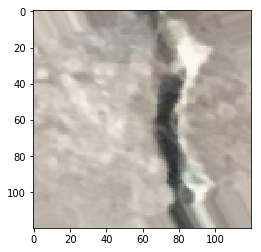

In [40]:
plt.imshow(imgs[0])

In [41]:
imgs[0].shape

(120, 120, 3)

In [61]:
def demo(X):
    input = Input((IMG_DIM, IMG_DIM, 3))
    x = PCAColorAugmentationGPU()(input)
    model = Model(input, x)

    # fix to train phase
    K.set_learning_phase(1)

    aug = model.predict(X)
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
        
    n_rows = 4
    n_cols = 8
    _, axs = plt.subplots(n_rows,n_cols, figsize=(16, 8))
    axs = axs.flatten()
    for img, ax in zip(aug, axs):
        ax.imshow(img)
        plt.subplots_adjust(wspace=.3, hspace=.4)
    plt.show()
    print(aug.shape)

<Figure size 576x576 with 0 Axes>

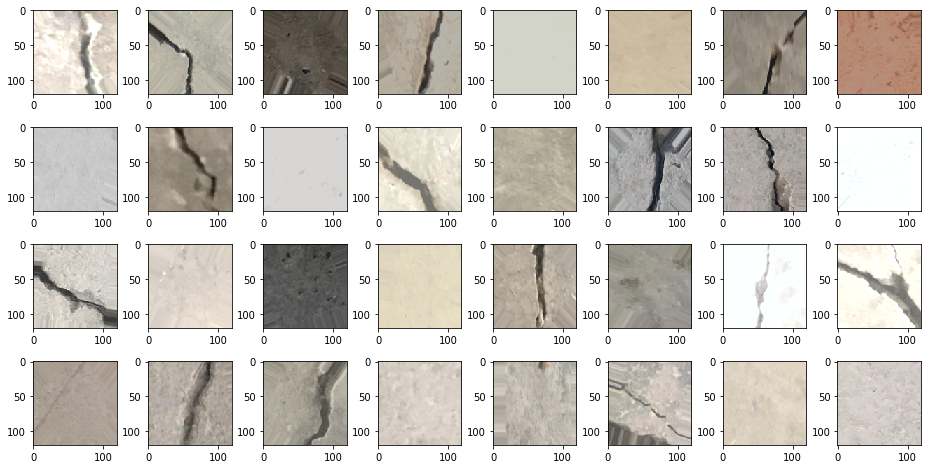

(32, 120, 120, 3)


In [62]:
demo(imgs)